# CropArray example

---

## Notebook summary 
- Load a microscope image of a shadow scope video
- Track 'circles' in the video and generate a dataframe with the locations
- Create a croparray with the image and dataframe
- Visualization tracks with Napari
- Digitally refocus top tracks of interest
----

## Importing libraries


----

Get the latest from 'main' w/ track id visualization fix
%pip install -U git+https://github.com/napari/napari.git

In [1]:
#%pip install -U git+https://github.com/napari/napari.git
#%pip install pyqt5  

In [2]:
# To manipulate arrays
import numpy as np 
from skimage.io import imread
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  
import pathlib # for working with windows paths
import sys
import cv2
import trackpy as tp
import pandas as pd
import xarray as xr
from skimage.filters import difference_of_gaussians, gaussian
current_dir = pathlib.Path().absolute()
croparray_dir = current_dir.parents[0].joinpath('croparray')
sys.path.append(str(croparray_dir))
import crop_array_tools as ca
# %matplotlib inline 
plt.style.use('dark_background')

In [3]:
# Napari 
%gui qt5 
import napari
from napari.utils import nbscreenshot

## Fresnel propagator 
____

In [4]:
# This Notebook uses the Frensel Propagator, from UC2's in-line holography workshop at:
# https://github.com/openUC2/UC2-GIT
def abssqr(x):
    # this is what a detector sees (only intensities)
    return np.real(x*np.conj(x))

def FT(x):
    # this only defines the correct fwd fourier transform including proper shift of the frequencies
    return np.fft.fftshift(np.fft.fft2(x)) # Fourier transform and shift

def iFT(x):
    # this only defines the correct inverse fourier transform including proper shift of the frequencies
    return np.fft.ifft2(np.fft.ifftshift(x)) # inverse Fourier transform and shift
    
def FresnelPropagator(E0, ps, lambda0, z):
    # Freespace propagation using Fresnel-kernel
    #
    # Inputs: 
    #             E0 - initial complex field in x-y source plane
    #             ps - pixel size in microns
    #             lambda0 - wavelength in nm
    #             z - z-value (distance from sensor to object)
    #             background - optional background image to divide out from
    #                
    # Outputs:
    #             Ef - Propagated output-field

    nx = E0.shape[1] # Image width in pixels (same as height)
    ny = E0.shape[0]
    gridx_size = ps * nx;  
    gridy_size = ps * nx; 

    # Inverse space
    fx = np.linspace(-(nx-1)/2*(1/gridx_size), (nx-1)/2*(1/gridx_size), nx)
    fy = np.linspace(-(ny-1)/2*(1/gridy_size), (ny-1)/2*(1/gridy_size), ny)
    Fx, Fy = np.meshgrid(fx, fy)
    
    # Fresnel kernel / point spread function h = H(kx, ky)
    # from Fourier Optics, chapter 4
    # H = sqrt(z*lambda0)*exp(1i*pi*lambda0*z*(Fx.^2+Fy.^2));
    H = np.exp(1j*(2 * np.pi / lambda0) * z) * np.exp(1j * np.pi * lambda0 * z * (Fx**2 + Fy**2))
    
    # Compute FFT centered about 0
    E0fft = FT((E0));     # Centered about 0 since fx and fy centered about 0
    G = H*E0fft
    Ef = iFT(G) # Output after backshifting Fourier transform
    
    return Ef

## Parameters for quantification


----

In [5]:
# define acquisition parameters
dxy = 1.4e-6 # in meters
lambdas = [630e-9, 532e-9, 465e-9] # red,green,blue wavelength in meters
dt = 1/30 # temporal resolution in sec
dz = np.linspace(0,0.0025,10)[1] # to reconstruct 3D image
channel_num = 3 # how many channels in movie
tracking_channel = 2 # channel used for tracking
channels=[0,1,2]

# tracking parameters
particle_radius = 20  # Spot diameter : y,x size of the spot      
padding = 35 # Amount to pad particle radius when making crop array
min_trajectory_length = 70    # Minimal number of frames to be consider as a trajectory
max_distance_movement = 35 # by eye, this seems pretty good for microscopic organisms
track_skip_frames = 2

#filename = 'waterflea-great-20201026-223810shadow_scope1.mp4'
filename = '834630658_shadow_scope1-cleantwirler-2.mp4'
#filename = 'party-elegans-20210121-090808shadow_scope1.mp4'
#filename = 'super-spin-20210121-082703shadow_scope1.mp4'
#filename = 'dot-tracking-plant-20210121-155902shadow_scope1.mp4'

bg_filename = 'bg.mp4'

## Loading data and detecting spots:

----

In [6]:
# Read in background
img_file_path = current_dir.parents[0].joinpath('dataBase','shadow_scope',bg_filename)  
# Reading a MP4 file
frames = []
spots = []
cap = cv2.VideoCapture(str(img_file_path))
ret = True
while ret:
    ret, img = cap.read() # read one frame from the 'capture' object; img is (H, W, C)
    if ret: 
        fImage = img
        # minFImage=np.min(fImage)
        # maxFImage=np.max(fImage)
        # scaledImage=(((fImage-minFImage)/(maxFImage-minFImage))*255).astype("uint8")
        # frames.append(scaledImage)
        frames.append(img)
imgbg = np.stack(frames, axis=0) # dimensions (T, H, W, C)  
bgimg = np.mean(imgbg,axis=0)
print("original image shape = ", imgbg.shape)
print("Image range:  (", np.min(imgbg), ',' , np.max(imgbg) ,')' )

original image shape =  (299, 1280, 1280, 3)
Image range:  ( 4 , 255 )


In [7]:
# Video directory
img_file_path = current_dir.parents[0].joinpath('dataBase','shadow_scope',filename)  
# Reading a Shadow Scope Video MP4 file
frames = []
spots = []
frames_orig = []
cap = cv2.VideoCapture(str(img_file_path))
ret = True
while ret:
    ret, img = cap.read() # read one frame from the 'capture' object; img is (H, W, C)
    if ret: 
        fImage = img-bgimg
        minFImage=np.min(fImage)
        maxFImage=np.max(fImage)
        scaledImage=(((fImage-minFImage)/(maxFImage-minFImage))*255).astype("uint8")
        circles = cv2.HoughCircles(img[:,:,tracking_channel],cv2.HOUGH_GRADIENT,1,40,param1=20,param2=15,minRadius=11,maxRadius=particle_radius)
        frames.append(scaledImage)
        frames_orig.append(img)
        spots.append(np.uint16(np.around(circles)))

img0 = np.stack(frames, axis=0) # dimensions (T, H, W, C)  
img0_orig = np.stack(frames_orig, axis=0) # not background subtracted

print("original image shape = ", img0.shape)
print("Image range:  (", np.min(img0), ',' , np.max(img0) ,')' )

original image shape =  (298, 1280, 1280, 3)
Image range:  ( 0 , 255 )


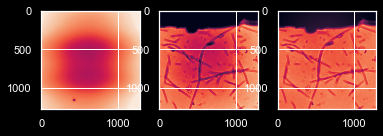

In [8]:
f, axes = plt.subplots(1,3)
axes[0].imshow(bgimg[:,:,2])
axes[1].imshow(img0_orig[0,:,:,2])
axes[2].imshow(img0[0,:,:,2])
plt.show()

In [9]:
# Make a dataframe with all the detected spot positions
mydf = []
for i in np.arange(len(img0)):
    temp = pd.DataFrame(data = spots[i][0], columns=['x','y','radius'])
    temp['frame']=i
    temp['z']=0
    mydf.append(temp)
mydf = pd.concat(mydf)

In [10]:
# Check out the dataframe
mydf.head()

,x,y,radius,frame,z
0,260,1048,19,0,0
1,400,1074,19,0,0
2,420,598,19,0,0
3,884,578,19,0,0
4,1070,156,19,0,0


In [11]:
for_napari = mydf.to_numpy()
i=[3,1,0,2] # re-order columns napari-like: ID,T,Y,X (no z or radius here)
napari_points = for_napari[:,i] # napari doesn't need radii

Now link the tracks and filter by length:

In [12]:
# link tracks
t = tp.link(mydf, max_distance_movement, memory=track_skip_frames)
t1 = tp.filter_stubs(t, min_trajectory_length)
t1['particle'] = t1['particle']+1 # VERY IMPORTANT NOT TO HAVE TRACK IDs WITH VALUES = 0 WHEN MAKING CROP ARRAYS
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Frame 297: 202 trajectories present.
Before: 6342
After: 135


In [13]:
# Check out the trackpy-like data-fram
t1.head()

,x,y,radius,frame,z,particle
frame,,,,,,
0,1228,746,14,0,0,3
0,182,526,17,0,0,7
0,554,360,12,0,0,15
0,416,316,14,0,0,27
0,832,1050,15,0,0,28


In [14]:
# drift correction...not worth it in our case
# d = tp.compute_drift(t1)
# d.plot()
# plt.show()
# #Subtrack drift, if worth it?
# tm = tp.subtract_drift(t1.copy(), d)
# x_velocity = tm['x'].rolling(window=10, min_periods=1).mean().diff(periods=1)*dxy/dt
# y_velocity =  tm['y'].rolling(window=10, min_periods=1).mean().diff(periods=1)*dxy/dt
# tm['velocity'] = np.sqrt(np.square(x_velocity)+np.square(y_velocity))
# avg_velocities = tm.groupby('particle').velocity.agg(['mean','min','max'])
# fast_tracks = a
# vg_velocities.sort_values(by=['mean'],ascending=False)
# fast_tracks.head()

In [15]:
# Determine velocity of tracks, for finding tracks of interest (higher velocity presumably interesting tracks)
# However, tracks with squiggles also interesting!? And longer tracks are interesting  4 mm/sec! So if they are 100 microns in size, or 0.1 mm, they travel 40 body lengths per sec; humans = 2M = 80 m/sec --> 288 km/hr! or 180 m/hr
x_velocity = t1['x'].rolling(window=10, min_periods=1).mean().diff(periods=1)*dxy/dt
y_velocity =  t1['y'].rolling(window=10, min_periods=1).mean().diff(periods=1)*dxy/dt
t1['velocity'] = np.sqrt(np.square(x_velocity)+np.square(y_velocity))

def maxmin(a):
    return a.max()-a.min()
agg_func = {
    'velocity': ['mean','max','min',maxmin]
}
avg_velocities = t1.groupby('particle').agg(agg_func)
fast_tracks = avg_velocities['velocity'].sort_values(by=['max'],ascending=False)
fast_tracks.head()

,mean,max,min,maxmin
particle,,,,
7,0.003014,0.022447,0.000072,0.022374
2857,0.003936,0.006596,0.000781,0.005815
171,0.003467,0.006568,0.000254,0.006314
3712,0.003821,0.006430,0.000091,0.006339
833,0.003886,0.006351,0.000036,0.006316


In [16]:
# bbox
def maxmin(a):
    return a.max()-a.min()
agg_func = {
    'x': ['max','min',maxmin], 'y':['max','min',maxmin]
}
bbox = t1.groupby('particle').agg(agg_func)
bbox['bounds']=bbox['x']['maxmin']+bbox['y']['maxmin']
bbox = bbox.sort_values(by='bounds',ascending=False)
bbox

x                  y              bounds
           max   min maxmin   max   min maxmin       
particle                                             
2691      1262   598    664  1258  1012    246    910
1785      1190   976    214  1270   788    482    696
34         994   612    382  1206  1156     50    432
1729       770   458    312  1260  1212     48    360
402       1036   928    108   554   314    240    348
...        ...   ...    ...   ...   ...    ...    ...
89        1046  1032     14   272   258     14     28
87         476   464     12   420   404     16     28
4683       574   562     12  1126  1116     10     22
1900       892   884      8   590   578     12     20
15         558   548     10   364   354     10     20

[135 rows x 7 columns]

In [17]:
t3 = []
lfts = len(bbox.index)
if lfts < 31:
    fts = bbox.index[0:lfts]
else:
    fts = bbox.index[0:30]
for j in fts: #fast_tracks.index[0:30]#
    t2 = t1[t1['particle']==j]
    t3.append(t2)
t4 = pd.concat(t3)
t4.index.name='fr'
t4.head()


,x,y,radius,frame,z,particle,velocity
fr,,,,,,,
122,1262,1110,17,122,0,2691,0.002125
123,1258,1116,19,123,0,2691,0.001753
124,1254,1104,19,124,0,2691,0.003177
125,1242,1096,15,125,0,2691,0.002172
126,1236,1092,15,126,0,2691,0.001724


## 3D Reconstruction of video:
____

In [18]:
zlist=np.linspace(0,0.0025,10)
img = []
for j in np.arange(img0.shape[0]):
    myzs=[]
    z_count = 0
    for i in zlist:
        z_count = round(z_count + 1/len(zlist),1)
        if ((z_count>0.2) & (z_count < 0.8)):
            bval = round((.8-z_count),1)
            #print('bval: ', bval)
            gval = round((0.2+z_count),1)
            #print ('gval: ', gval)
        else:
            bval = 1
            gval = 1
        #print(z_count)
        mychs=[]
        #for ch in [2]:
        fImage0 = FresnelPropagator(img0[j,:,:,tracking_channel], dxy, lambdas[tracking_channel], i)
        fImage = abssqr(fImage0)
        minFImage=np.min(fImage)
        maxFImage=np.max(fImage)
        imageR = (((fImage-minFImage)/(maxFImage-minFImage+.001))*255).astype('uint8')
        imageG = (imageR*z_count).astype('uint8')
        imageB = (imageR*bval).astype('uint8')
        mychs = [imageR,imageG,imageB]
        #mychs.append(image)
        myzs.append(mychs)
    img.append(myzs)
img = np.array(img,dtype='uint8')
img = np.transpose(img,(0,1,3,4,2))

In [19]:
# viewer = napari.view_image(img[0:20,:,:,:,0],colormap='gray',contrast_limits=[0,255])

In [20]:
# viewer = napari.view_image(np.invert(img[0:20,2:9,:,:,0]),colormap='red',contrast_limits=[200,255])
# viewer.add_image(np.invert(img[0:20,2:9,:,:,2]),colormap='green',blending='additive',contrast_limits=[250,255])
# viewer.add_image(np.invert(img[0:20,2:9,:,:,1]),colormap='blue',blending='additive',contrast_limits=[250,255])


In [28]:
out = np.max(np.invert(img[:,2:9]).astype('uint8'),axis=1).astype('uint8')

In [29]:
dimname = os.path.join(r'../database/shadow_scope','refocused_dimRGB_'+filename[0:-4]+'.mp4')

In [161]:
# Save bright and dim background style: 
rmin,rmax=200,255
gmin,gmax=250,255
bmin,bmax=246,255
out2 = np.copy(out)
out2[:,:,:,2] = ((np.clip(out[:,:,:,0],rmin,rmax)-rmin)/(rmax-rmin)*255).astype('uint8')
out2[:,:,:,0] = ((np.clip(out[:,:,:,1],gmin,gmax)-gmin)/(gmax-gmin)*255).astype('uint8')
out2[:,:,:,1] = ((np.clip(out[:,:,:,2],bmin,bmax)-bmin)/(bmax-bmin)*255).astype('uint8')

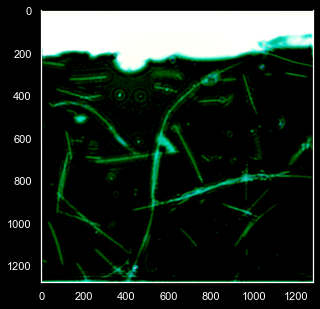

In [162]:
# Check a frame
plt.figure(figsize=(5,5))
plt.imshow(out2[200])
plt.grid(False)

In [163]:
# BGR (not RGB...so swap red and blue above)
#codec = cv2.VideoWriter_fourcc('X', 'V', 'I', 'D')
codec = cv2.VideoWriter_fourcc('H', '2', '6', '4')
writer = cv2.VideoWriter(dimname,codec, 30, (1280,1280) )
for i in range(out.shape[0]):
    writer.write(out2[i])
writer.release()

## Visualize everything in napari
____

In [32]:
# First we add the main video
viewer = napari.view_image(img0[:,:,:,tracking_channel], name='image',blending='additive')
# We next visualize the points
points_layer = viewer.add_points(napari_points[:,0:3], size=30,edge_color='red',symbol='ring',opacity=0.5,face_color='red')
# Last we add the tracks. These need to first be converted to napari form:
test = t4.to_numpy()
sorted = test[np.lexsort((test[:,3],test[:,5]))] # sort by track ('particle') and then by time ('frame')
i=[5,3,1,0,2,4] # re-order columns napari-like: ID,T,Z,Y,X
napari_tracks = sorted[:,i]
viewer.add_tracks(napari_tracks[:,0:4], name='tracks', tail_length=150)

<Tracks layer 'tracks' at 0x1e4d50231c0>

## Create Crop Array
____

Converting the video to Croparray format

In [23]:
img_croparray = np.expand_dims(img,axis=0) # expanding to include z
#img_croparray = np.expand_dims(img_croparray, axis=0)
print("croparray format shape [fov,f,z,y,x,ch] = ", img_croparray.shape)

croparray format shape [fov,f,z,y,x,ch] =  (1, 298, 10, 1280, 1280, 3)


Convert the trackpy-like data array to crop-array format:

In [24]:
spots = t4.copy()  # just take the interesting tracks
spots.rename(columns={'x':'xc','y':'yc','frame': 'f','particle': 'id'}, inplace=True, errors='raise')
 # Here we need to create an fov column since there was only 1 fov with the sample dataset. Can give it a name, but note that in the crop array it will be assigned a unique fov integer number starting from 0
spots['fov']='no-art'
# can include other optional columns for making layers, like 'ID', and 'MEAN_INTENSITY'
spots = spots[['fov','id','f','yc','xc','radius']]  
spots.head()

,fov,id,f,yc,xc,radius
fr,,,,,,
122,no-art,2691,122,1110,1262,17
123,no-art,2691,123,1116,1258,19
124,no-art,2691,124,1104,1254,19
125,no-art,2691,125,1096,1242,15
126,no-art,2691,126,1092,1236,15


In [25]:
my_ca = ca.create_crop_array(img_croparray,spots,xy_pad=particle_radius+padding,dx=dxy,dy=dxy,dz=dz,dt=1/30,units=['m','s'],name=filename)
my_ca.attrs['notes'] = 'A crop array from the shadow-scope'
my_ca

Original video dimensions:  (1, 298, 10, 1280, 1280, 3)
Padded video dimensions:  (1, 298, 10, 1392, 1392, 3)
Max # of spots per frame:  20
Shape of numpy array to hold all crop intensity data:  (1, 20, 298, 10, 111, 111, 3)
Shape of xc and yc numpy arrays:  (1, 20, 298, 3)
Shape of extra my_layers numpy array:  (2, 1, 20, 298)


<xarray.Dataset>
Dimensions:  (fov: 1, n: 20, t: 298, z: 10, y: 111, x: 111, ch: 3)
Coordinates:
  * fov      (fov) int32 0
  * n        (n) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * t        (t) float64 0.0 0.03333 0.06667 0.1 0.1333 ... 9.8 9.833 9.867 9.9
  * z        (z) float64 0.0 0.0002778 0.0005556 ... 0.001944 0.002222 0.0025
  * y        (y) float64 -7.7e-05 -7.56e-05 -7.42e-05 ... 7.56e-05 7.7e-05
  * x        (x) float64 -7.7e-05 -7.56e-05 -7.42e-05 ... 7.56e-05 7.7e-05
  * ch       (ch) int32 0 1 2
Data variables:
    int      (fov, n, t, z, y, x, ch) int32 
    xc       (fov, n, t, ch) int32 1050 1050 1050 1034 1034 1034 ... 0 0 0 0 0 0
    yc       (fov, n, t, ch) int32 1250 1250 1250 1246 1246 1246 ... 0 0 0 0 0 0
    dx       float64 1.4e-06
    dy       float64 1.4e-06
    dz       float64 0.0002778
    dt       float64 0.03333
    xy_pad   int32 55
    id       (fov, n, t) float64 34.0 34.0 94.0 34.0 34.0 ... 0.0 0.0 0.0 0.0
    radius   (fov, n, t) float64 17.0 15.0 17.0 12.0 19.0 ... 0.0 0.0 0.0 0.0
Attributes:
    name:     834630658_shadow_scope1-cleantwirler-2.mp4
    date:     video_date
    notes:    A crop array from the shadow-scope

In [26]:
# Since ids correspond to tracks, we can organize tracks in rows  
my_ids = np.unique(my_ca.id) # Find all unique ids
my_ids = my_ids[1:] # remove the '0' ID used as filler in Crop Arrays
my_ids
# Get a list of xarrays for each unique id 
my_das = []
for i in np.arange(len(my_ids)):
    temp = my_ca.groupby('id')[my_ids[i]].reset_index('stacked_fov_n_t').reset_coords('n',drop=True).reset_coords('fov',drop=True).swap_dims({'stacked_fov_n_t':'t'})
    my_das.append(temp)
    del temp
# Concatenate the xarrays together to make a new xarray dataset in a track array format (each track on separate row). Here 'n' is replaced by 'tracks'
my_taz = xr.concat(my_das, dim=pd.Index(my_ids, name='track_id'), fill_value=255) # fill_value=0 so keep int instead of moving to floats with NaNs
my_taz = my_taz.transpose('track_id','fov','n','t','z','y','x','ch', missing_dims='ignore') # reorder for napari
my_taz

<xarray.Dataset>
Dimensions:   (t: 298, z: 10, y: 111, x: 111, ch: 3, track_id: 30)
Coordinates:
  * t         (t) float64 0.0 0.03333 0.06667 0.1 0.1333 ... 9.8 9.833 9.867 9.9
  * z         (z) float64 0.0 0.0002778 0.0005556 ... 0.001944 0.002222 0.0025
  * y         (y) float64 -7.7e-05 -7.56e-05 -7.42e-05 ... 7.56e-05 7.7e-05
  * x         (x) float64 -7.7e-05 -7.56e-05 -7.42e-05 ... 7.56e-05 7.7e-05
  * ch        (ch) int32 0 1 2
  * track_id  (track_id) float64 34.0 94.0 139.0 ... 4.205e+03 4.514e+03
Data variables:
    int       (track_id, t, z, y, x, ch) int32 
    xc        (track_id, t, ch) int32 1050 1050 1050 1034 ... 694 692 692 692
    yc        (track_id, t, ch) int32 1250 1250 1250 1246 ... 796 808 808 808
    dx        (track_id) float64 1.4e-06 1.4e-06 1.4e-06 ... 1.4e-06 1.4e-06
    dy        (track_id) float64 1.4e-06 1.4e-06 1.4e-06 ... 1.4e-06 1.4e-06
    dz        (track_id) float64 0.0002778 0.0002778 ... 0.0002778 0.0002778
    dt        (track_id) float64 0.03333 0.03333 0.03333 ... 0.03333 0.03333
    xy_pad    (track_id) int32 55 55 55 55 55 55 55 55 ... 55 55 55 55 55 55 55
    id        (track_id, t) float64 34.0 34.0 255.0 ... 4.514e+03 4.514e+03
    radius    (track_id, t) float64 17.0 15.0 255.0 12.0 ... 15.0 15.0 15.0 19.0
Attributes:
    name:     834630658_shadow_scope1-cleantwirler-2.mp4
    date:     video_date
    notes:    A crop array from the shadow-scope

In [ ]:
# # # View individual tracks by scrolling through them
# viewer=napari.view_image(my_taz.int,contrast_limits=[0,255])

In [32]:
shadow_z_signal = my_taz.int.where(lambda a: (a.x**2 + a.y**2 <= (6*my_ca.dx)**2)).mean(['x','y'])#.plot(col='t', col_wrap=5)

In [33]:
my_taz['shadow_z_signal'] = shadow_z_signal 

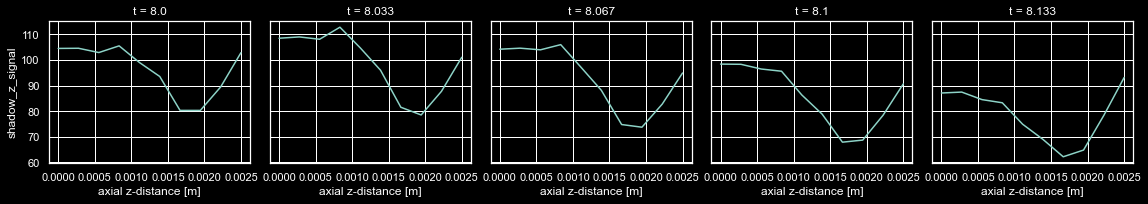

In [68]:
my_taz.isel(track_id=19,ch=0,t=slice(240,245)).shadow_z_signal.plot(col='t',col_wrap=5)

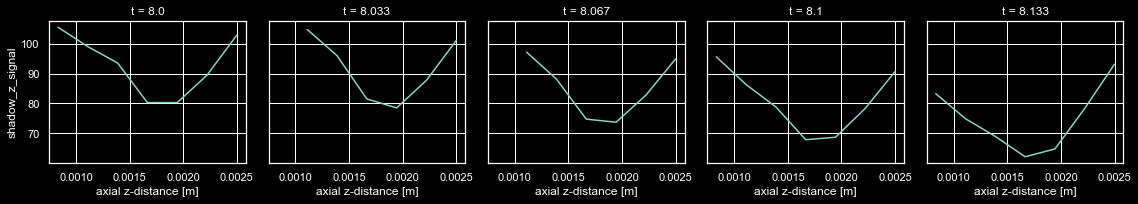

In [88]:
# Choose z-plane in ca.int corresponding to max z-signal for each channel, then concatenate x-arrays with coordinate channels
z_fitting_data = my_taz.shadow_z_signal.where(lambda a: np.abs(a.z/dz - my_taz.shadow_z_signal.argmin(dim='z')) <= 3).isel(ch=0)
z_fitting_data.isel(track_id=19,t=slice(240,245)).plot(col='t',col_wrap=5)

array(0.0025)

In [157]:
my_taz.t

<xarray.DataArray 't' (t: 298)>
array([0.      , 0.033333, 0.066667, ..., 9.833333, 9.866667, 9.9     ])
Coordinates:
  * t        (t) float64 0.0 0.03333 0.06667 0.1 0.1333 ... 9.8 9.833 9.867 9.9

True

In [228]:
    ydata0,xdata0 = z_fitting_data.isel(track_id=19,t=123).data, my_taz.z.data
    xdata1,ydata1 = xdata0*ydata0/ydata0 , ydata0
    xdata,ydata = xdata1[~np.isnan(xdata1)],ydata1[~np.isnan(ydata1)]
    xdatafine = np.linspace(my_taz.z.min().data,my_taz.z.max().data)
    print(xdata,ydata)
    popt, pcov = curve_fit(my_parabola, xdata, ydata,p0=(0.0016,4e7,80))
    print('fitted [zo, a, b] = ', popt)

[0.         0.00027778 0.00055556 0.00083333] [ 85.83185841  89.07964602  98.13274336 109.60176991]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [226]:
# fit the z-values of all tracks,125
fitted_zs = np.zeros(len(my_taz.t))
for i in np.arange(123,124):
    ydata0,xdata0 = z_fitting_data.isel(track_id=19,t=i).data, my_taz.z.data
    xdata1,ydata1 = xdata0*ydata0/ydata0 , ydata0
    xdata,ydata = xdata1[~np.isnan(xdata1)],ydata1[~np.isnan(ydata1)]
    xdatafine = np.linspace(my_taz.z.min().data,my_taz.z.max().data)
    #print(xdata,ydata)
    popt, pcov = curve_fit(my_parabola, xdata, ydata,p0=(0.0016,4e7,80))
    #print('fitted [zo, a, b] = ', popt)
    #print('fitted z = ', popt[0])
    #plt.plot(xdata, ydata, 'b-', label='data')
    #plt.plot(xdatafine, my_parabola(xdatafine, *popt), 'r-',
    #         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [218]:
fitted_zs

array([7.6197783e-01, 7.6197783e-01, 7.6197783e-01, 7.6197783e-01,
       7.6197783e-01, 7.6197783e-01, 7.6197783e-01, 7.6197783e-01,
       7.6197783e-01, 7.6197783e-01, 7.6197783e-01, 7.6197783e-01,
       7.6197783e-01, 7.6197783e-01, 7.6197783e-01, 7.6197783e-01,
       7.6197783e-01, 7.6197783e-01, 7.6197783e-01, 7.6197783e-01,
       7.6197783e-01, 7.6197783e-01, 7.6197783e-01, 7.6197783e-01,
       7.6197783e-01, 7.6197783e-01, 7.6197783e-01, 7.6197783e-01,
       7.6197783e-01, 7.6197783e-01, 7.6197783e-01, 7.6197783e-01,
       7.6197783e-01, 7.6197783e-01, 7.6197783e-01, 7.6197783e-01,
       7.6197783e-01, 7.6197783e-01, 7.6197783e-01, 7.6197783e-01,
       7.6197783e-01, 7.6197783e-01, 7.6197783e-01, 7.6197783e-01,
       7.6197783e-01, 7.6197783e-01, 7.6197783e-01, 7.6197783e-01,
       7.6197783e-01, 7.6197783e-01, 7.6197783e-01, 7.6197783e-01,
       7.6197783e-01, 7.6197783e-01, 7.6197783e-01, 7.6197783e-01,
       7.6197783e-01, 7.6197783e-01, 7.6197783e-01, 7.6197783e

In [111]:
from scipy.optimize import curve_fit
def my_parabola(z, z0, a, b):
    return a * (z-z0)**2 + b

## Visualize Tracks (convert crop array to track array)
____

In [23]:
# #Export and maintain 8-bit nature of original movie
# my_ca.to_netcdf(current_dir.parents[0].joinpath('dataBase','shadow_scope',filename[:-4]+'_crop_array.nc'), encoding={'int': {'dtype': 'int8'}} )

In [24]:
# my_ca = xr.open_dataset(current_dir.parents[0].joinpath('dataBase','shadow_scope',filename[:-4]+'_crop_array.nc'))

In [21]:
# Since ids correspond to tracks, we can organize tracks in rows  
my_ids = np.unique(my_ca.id) # Find all unique ids
my_ids = my_ids[1:] # remove the '0' ID used as filler in Crop Arrays
my_ids

array([  34.,   94.,  139.,  159.,  402.,  546.,  915., 1168., 1274.,
       1333., 1416., 1417., 1447., 1730., 1786., 1917., 2009., 2411.,
       2581., 2693., 3277., 3399., 3523., 3612., 3664., 3816., 3919.,
       4197., 4208., 4517.])

In [22]:
# Get a list of xarrays for each unique id 
my_das = []
for i in np.arange(len(my_ids)):
    temp = my_ca.groupby('id')[my_ids[i]].reset_index('stacked_fov_n_t').reset_coords('n',drop=True).reset_coords('fov',drop=True).swap_dims({'stacked_fov_n_t':'t'})
    my_das.append(temp)
    del temp

In [23]:
# Concatenate the xarrays together to make a new xarray dataset in a track array format (each track on separate row). Here 'n' is replaced by 'tracks'
my_ta = xr.concat(my_das, dim=pd.Index(my_ids, name='track_id'), fill_value=255) # fill_value=0 so keep int instead of moving to floats with NaNs
my_ta = my_ta.transpose('track_id','fov','n','t','z','y','x','ch', missing_dims='ignore') # reorder for napari

In [24]:
x_velocity = my_ta.xc.rolling(t=10,center=True,min_periods=1).mean().diff('t', 1# calculate velocity
    ).pad(t=(0,1) # pad only on right to get back original dimensions
    , constant_values=0)
y_velocity = my_ta.yc.rolling(t=10,center=True,min_periods=1).mean().diff('t',1 # calculate velocity
    ).pad(t=(0,1) # pad only on right to get back original dimensions
    , constant_values=0)
velocity = np.sqrt(np.square(x_velocity)+np.square(y_velocity))
my_ta['velocity'] = velocity
np.min(my_ta.velocity).data,np.max(my_ta.velocity).data

(array(0.), array(142.83087901))

In [25]:
my_ta = my_ta.sortby(my_ta.velocity.sel(ch=2).mean('t'),ascending=False)
my_ta

<xarray.Dataset>
Dimensions:   (t: 298, z: 1, y: 111, x: 111, ch: 3, track_id: 30)
Coordinates:
  * t         (t) float64 0.0 0.03333 0.06667 0.1 0.1333 ... 9.8 9.833 9.867 9.9
  * z         (z) float64 0.0
  * y         (y) float64 -7.7e-05 -7.56e-05 -7.42e-05 ... 7.56e-05 7.7e-05
  * x         (x) float64 -7.7e-05 -7.56e-05 -7.42e-05 ... 7.56e-05 7.7e-05
  * ch        (ch) int32 0 1 2
  * track_id  (track_id) float64 1.168e+03 1.73e+03 915.0 ... 3.399e+03 94.0
Data variables:
    int       (track_id, t, z, y, x, ch) int32 255 255 255 255 ... 73 144 157 78
    xc        (track_id, t, ch) int32 255 255 255 255 255 ... 554 554 554 554
    yc        (track_id, t, ch) int32 255 255 255 255 255 ... 730 728 728 728
    dx        (track_id) float64 1.4e-06 1.4e-06 1.4e-06 ... 1.4e-06 1.4e-06
    dy        (track_id) float64 1.4e-06 1.4e-06 1.4e-06 ... 1.4e-06 1.4e-06
    dz        (track_id) float64 0.0002778 0.0002778 ... 0.0002778 0.0002778
    dt        (track_id) float64 0.03333 0.03333 0.03333 ... 0.03333 0.03333
    xy_pad    (track_id) int32 55 55 55 55 55 55 55 55 ... 55 55 55 55 55 55 55
    id        (track_id, t) float64 255.0 255.0 255.0 255.0 ... 94.0 94.0 94.0
    radius    (track_id, t) float64 255.0 255.0 255.0 255.0 ... 17.0 16.0 17.0
    velocity  (track_id, t, ch) float64 nan nan nan 0.0 ... 1.001 1.001 1.001
Attributes:
    name:     834630658_shadow_scope1-cleantwirler-2.mp4
    date:     video_date
    notes:    A crop array from the shadow-scope

In [34]:
# # view montage of tracks [rows= time, columns = spot number]
my_ta_montage= ca.montage(my_ta.sel(ch=2,z=0), row = 'track_id', col = 'track_id')

In [35]:
viewer=napari.view_image(my_ta_montage.int.fillna(0))
viewer.add_image(my_ta_montage.velocity.fillna(0), colormap = 'green', name = 'velocity', blending='translucent',opacity=0.5)
# # View individual tracks by scrolling through them
viewer.add_image(my_ta_montage.id.fillna(0), colormap = 'red', name = 'id', blending='translucent',opacity=0.5)

<Image layer 'id' at 0x1680b660b80>

In [65]:
# # View individual tracks by scrolling through them
viewer=napari.view_image(my_ta.int.sel(ch=2,z=0))

# Crop Array from refocused image

In [33]:
# Create dataframe from fast tracks
spots = t4.copy()  # just take the interesting tracks
spots.rename(columns={'x':'xc','y':'yc','frame': 'f','particle': 'id'}, inplace=True, errors='raise')
 # Here we need to create an fov column since there was only 1 fov with the sample dataset. Can give it a name, but note that in the crop array it will be assigned a unique fov integer number starting from 0
spots['fov']='no-art'
# can include other optional columns for making layers, like 'ID', and 'MEAN_INTENSITY'
spots = spots[['fov','id','f','yc','xc','radius']]  
spots.head()

,fov,id,f,yc,xc,radius
fr,,,,,,
122,no-art,2693,122,1110,1262,17
123,no-art,2693,123,1116,1258,19
124,no-art,2693,124,1104,1254,19
125,no-art,2693,125,1096,1242,15
126,no-art,2693,126,1092,1236,15


In [34]:
my_caz = ca.create_crop_array(np.expand_dims(np.expand_dims(out2,1),0),spots,xy_pad=particle_radius+padding,dx=dxy,dy=dxy,dz=dz,dt=1/30,units=['m','s'],name=filename)
my_caz.attrs['notes'] = 'A crop array from the shadow-scope'
my_caz

Original video dimensions:  (1, 298, 1, 1280, 1280, 3)
Padded video dimensions:  (1, 298, 1, 1392, 1392, 3)
Max # of spots per frame:  20
Shape of numpy array to hold all crop intensity data:  (1, 20, 298, 1, 111, 111, 3)
Shape of xc and yc numpy arrays:  (1, 20, 298, 3)
Shape of extra my_layers numpy array:  (2, 1, 20, 298)


<xarray.Dataset>
Dimensions:  (fov: 1, n: 20, t: 298, z: 1, y: 111, x: 111, ch: 3)
Coordinates:
  * fov      (fov) int32 0
  * n        (n) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * t        (t) float64 0.0 0.03333 0.06667 0.1 0.1333 ... 9.8 9.833 9.867 9.9
  * z        (z) float64 0.0
  * y        (y) float64 -7.7e-05 -7.56e-05 -7.42e-05 ... 7.56e-05 7.7e-05
  * x        (x) float64 -7.7e-05 -7.56e-05 -7.42e-05 ... 7.56e-05 7.7e-05
  * ch       (ch) int32 0 1 2
Data variables:
    int      (fov, n, t, z, y, x, ch) int32 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    xc       (fov, n, t, ch) int32 1050 1050 1050 1034 1034 1034 ... 0 0 0 0 0 0
    yc       (fov, n, t, ch) int32 1250 1250 1250 1246 1246 1246 ... 0 0 0 0 0 0
    dx       float64 1.4e-06
    dy       float64 1.4e-06
    dz       float64 0.0002778
    dt       float64 0.03333
    xy_pad   int32 55
    id       (fov, n, t) float64 34.0 34.0 94.0 34.0 34.0 ... 0.0 0.0 0.0 0.0
    radius   (fov, n, t) float64 17.0 15.0 17.0 12.0 19.0 ... 0.0 0.0 0.0 0.0
Attributes:
    name:     834630658_shadow_scope1-cleantwirler-2.mp4
    date:     video_date
    notes:    A crop array from the shadow-scope

In [35]:
# Since ids correspond to tracks, we can organize tracks in rows  
my_ids = np.unique(my_caz.id) # Find all unique ids
my_ids = my_ids[1:] # remove the '0' ID used as filler in Crop Arrays
my_ids
# Get a list of xarrays for each unique id 
my_das = []
for i in np.arange(len(my_ids)):
    temp = my_caz.groupby('id')[my_ids[i]].reset_index('stacked_fov_n_t').reset_coords('n',drop=True).reset_coords('fov',drop=True).swap_dims({'stacked_fov_n_t':'t'})
    my_das.append(temp)
    del temp
# Concatenate the xarrays together to make a new xarray dataset in a track array format (each track on separate row). Here 'n' is replaced by 'tracks'
my_taz = xr.concat(my_das, dim=pd.Index(my_ids, name='track_id'), fill_value=255) # fill_value=0 so keep int instead of moving to floats with NaNs
my_taz = my_taz.transpose('track_id','fov','n','t','z','y','x','ch', missing_dims='ignore') # reorder for napari
my_taz

<xarray.Dataset>
Dimensions:   (t: 298, z: 1, y: 111, x: 111, ch: 3, track_id: 30)
Coordinates:
  * t         (t) float64 0.0 0.03333 0.06667 0.1 0.1333 ... 9.8 9.833 9.867 9.9
  * z         (z) float64 0.0
  * y         (y) float64 -7.7e-05 -7.56e-05 -7.42e-05 ... 7.56e-05 7.7e-05
  * x         (x) float64 -7.7e-05 -7.56e-05 -7.42e-05 ... 7.56e-05 7.7e-05
  * ch        (ch) int32 0 1 2
  * track_id  (track_id) float64 34.0 94.0 139.0 ... 4.208e+03 4.517e+03
Data variables:
    int       (track_id, t, z, y, x, ch) int32 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    xc        (track_id, t, ch) int32 1050 1050 1050 1034 ... 694 692 692 692
    yc        (track_id, t, ch) int32 1250 1250 1250 1246 ... 796 808 808 808
    dx        (track_id) float64 1.4e-06 1.4e-06 1.4e-06 ... 1.4e-06 1.4e-06
    dy        (track_id) float64 1.4e-06 1.4e-06 1.4e-06 ... 1.4e-06 1.4e-06
    dz        (track_id) float64 0.0002778 0.0002778 ... 0.0002778 0.0002778
    dt        (track_id) float64 0.03333 0.03333 0.03333 ... 0.03333 0.03333
    xy_pad    (track_id) int32 55 55 55 55 55 55 55 55 ... 55 55 55 55 55 55 55
    id        (track_id, t) float64 34.0 34.0 255.0 ... 4.517e+03 4.517e+03
    radius    (track_id, t) float64 17.0 15.0 255.0 12.0 ... 15.0 15.0 15.0 19.0
Attributes:
    name:     834630658_shadow_scope1-cleantwirler-2.mp4
    date:     video_date
    notes:    A crop array from the shadow-scope

In [36]:
# # View individual tracks by scrolling through them
viewer=napari.view_image(my_taz.int,contrast_limits=[0,255])

In [44]:
# # view montage of tracks [rows= time, columns = spot number]
my_taz_montage= ca.montage(my_taz.sel(ch=2), row = 'track_id', col = 'track_id')

In [45]:
viewer=napari.view_image(my_taz_montage.int.fillna(0), contrast_limits=[0,255])

# Demonstrating Fresnel diffraction and shadow imaging

In [137]:
import matplotlib.image as mpimg
img = mpimg.imread( current_dir.parents[0].joinpath('dataBase','shadow_scope','tail.png'))

In [138]:
zlist=np.linspace(0,0.0025,10)
myzs=[]
z_count = 0
for i in zlist:
    fImage0 = FresnelPropagator(img[:,:,0], dxy, lambdas[tracking_channel], i)
    fImage = abssqr(fImage0)
    minFImage=np.min(fImage)
    maxFImage=np.max(fImage)
    imageR = (((fImage-minFImage)/(maxFImage-minFImage+.001))*255).astype('uint8')
    myzs.append(imageR)
myzs = np.array(myzs,dtype='uint8')

In [139]:
viewer = napari.view_image(myzs)

# Batch processing

In [5]:
# define acquisition parameters
dxy = 1.4e-6 # in meters
lambdas = [630e-9, 532e-9, 465e-9] # red,green,blue wavelength in meters
dt = 1/30 # temporal resolution in sec
dz = np.linspace(0,0.0025,10)[1] # to reconstruct 3D image
channel_num = 3 # how many channels in movie
tracking_channel = 2 # channel used for tracking
channels=[0,1,2]

# tracking parameters
particle_radius = 20  # Spot diameter : y,x size of the spot      
padding = 35 # Amount to pad particle radius when making crop array
min_trajectory_length = 70    # Minimal number of frames to be consider as a trajectory
max_distance_movement = 35 # by eye, this seems pretty good for microscopic organisms
track_skip_frames = 2
 
directory = r''
bg_filename = 'bg.mp4'